## Image Classification

[CIFAR-10](http://www.cs.toronto.edu/~kriz/cifar.html) is the dataset we are using for this assignment.

In [1]:
# Package install
import torch
import torchvision
import torchvision.transforms as transforms

F:\python3.68\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
F:\python3.68\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
F:\python3.68\lib\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
  stacklevel=1)


## Load dataset

In [2]:
# Choose a batch size that feed into NN
batch_size = 256

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## Show images

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

<Figure size 640x480 with 1 Axes>

  cat  deer  deer  ship


## CNN model

* 4 Conv Layer
* 4 Batch Norm Layer
* 4 Max Pool Layer
* 4 Dropout Layer

In [4]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        
        # Conv layer keep the dimension of input image or 
        # prior layer data (extract features/generate feature maps or filters), 
        # while pooling layer decrease the data dimension exponentially (extract more important feature)
        
        # Conv2d - Convolutional layer: extract the features from the input images, ex. edge, pattern
        self.conv1 = nn.Conv2d(3, 64, 5) #in_channels = 3 RGB the input channels of prior layer or input image
                                        #out_channels = 16 the number of filters
                                        #kernel_size = 5 the convolutional kernel/filter feature sizes
                                        #Finally, we will input 3 channels RGB image and produce 16 different
                                        # filters of (5,5) kernal size
        
        # MaxPool2d - max pooling layer
        #Preserve the information but get rid of large portion of features, which are not important
        #Redure number of parameter of the finals in neural network
        #Avoid overfitting, disregarding the unnecessary information
        self.pool = nn.MaxPool2d(3, stride=2, padding=1)#kernel_size = 3 size of the max map
                                                        #stride = 2 how many stride shifts over the input matrix
        self.conv2 = nn.Conv2d(64, 128, 5)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv4 = nn.Conv2d(256, 512, 3, padding=1)
        # Use for dim transformation
        self.fc1 = nn.Linear(512*2*2, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        # Batchnorlization takes the output dim of prior layer as the input dim
        # It reduces overfitting because it has a slight regularization effects. 
        # Similar to Dropout, it adds some noise to each hidden layer’s activations
        # subtracting the batch mean and dividing by the batch standard deviation
        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn3 = nn.BatchNorm2d(256)
        self.bn4 = nn.BatchNorm2d(512)
        # Dropout some number of layer outputs are randomly ignored or “dropped out.”
        self.dropout = nn.Dropout(0.3)


    def forward(self, x):
        # We first use the conv layer to extract information and then batch normalize
        # Then dropout some neurons with 0.3 probability in order to avoid overfitting
        # Then use relu activation to remove the negative value
        # Finally use the max pool technique to preserve information
        x = self.pool(F.relu(self.dropout(self.bn1(self.conv1(x)))))
        x = self.pool(F.relu(self.dropout(self.bn2(self.conv2(x)))))
        x = self.pool(F.relu(self.dropout(self.bn3(self.conv3(x)))))
        x = self.pool(F.relu(self.dropout(self.bn4(self.conv4(x)))))
        # Flatten the output of the prior layers in order to feed into linear functions
        x = x.view(-1, 512*2*2)
        # We use linear function to matrix operation for output the dim that we would like to
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        # Output our desired output dim - 10
        x = self.fc3(x)
        return x


net = Net()

In [5]:
import torch.optim as optim

# This is the cross entropy loss that we use to calculate the losses
criterion = nn.CrossEntropyLoss()
# Our optimizer is Stochastic gradient descent with predefined learning rate and momentum
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

In [6]:
# If GPU is available, deploy the model on it
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)

Net(
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=2048, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

In [7]:
from tqdm.notebook import tqdm
losses = []
acc = []
for epoch in tqdm(range(1000)):  # loop over the dataset multiple times
    correct = 0
    total = 0
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
#         print(inputs.shape)
        # forward + backward + optimize
        outputs = net(inputs)
#         print(outputs.shape, labels.shape)

        # Calculate the loss by the output of CNN and true labels
        loss = criterion(outputs, labels)
        # Backpropagation by the selection of optimizer: SGD
        loss.backward()
        # Update the gradient
        optimizer.step()
        
        # Get our predicted class
        _, predicted = torch.max(outputs.data, 1)
        # Accuracy
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        acc.append(correct/total)
        losses.append(loss)
        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')


Finished Training


### Train accuracy, loss plot

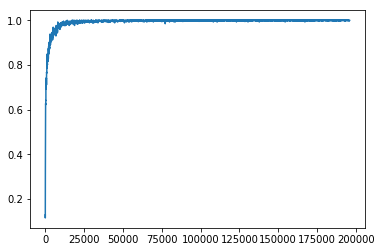

In [8]:
import matplotlib.pyplot as plt
plt.plot(acc)
# plt.plot(acc)
plt.show()

### Test image

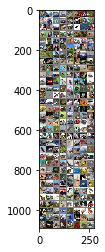

GroundTruth:    cat  ship  ship plane  frog  frog   car  frog   cat   car plane truck   dog horse truck  ship   dog horse  ship  frog horse plane  deer truck   dog  bird  deer plane truck  frog  frog   dog  deer   dog truck  bird  deer   car truck   dog  deer  frog   dog  frog plane truck   cat truck horse  frog truck  ship plane   cat  ship  ship horse horse  deer  frog horse   cat  frog   cat  frog  bird   car  bird   cat horse  bird  frog  ship  ship plane  bird truck   cat   cat  ship  ship   car   car horse  bird   dog  bird horse  ship truck plane   cat  ship  frog  deer  frog  frog plane plane horse  deer   dog  frog   cat   car   car   cat  frog  ship horse  deer plane  frog  bird   car   cat plane  deer  bird horse  ship   cat   car  bird  ship plane  ship   cat   dog  bird  deer   car  ship truck   car  bird truck horse  bird truck  frog   dog  frog   cat  ship horse  frog  bird   dog  bird  ship truck  frog plane plane   dog  bird truck   dog  deer  bird   car  frog  frog  s

In [9]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [10]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(80)))

Predicted:   ship plane truck  ship  deer  ship  bird   car   car plane truck  bird plane truck horse  frog horse plane   dog  ship horse  deer   dog   cat  deer  bird   dog  deer truck plane  deer  ship  bird   cat   car   car   cat truck   car plane   dog plane   car horse  frog horse  frog plane  frog   dog horse plane  ship  bird   car plane   car   dog  frog plane horse  ship truck horse horse  frog  bird horse   cat  ship  bird truck truck  deer horse horse horse horse horse   dog


### Test accuracy

In [11]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 83 %


### Test accuracy by class

In [12]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(16):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
            

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 83 %
Accuracy of   car : 91 %
Accuracy of  bird : 83 %
Accuracy of   cat : 69 %
Accuracy of  deer : 89 %
Accuracy of   dog : 70 %
Accuracy of  frog : 83 %
Accuracy of horse : 92 %
Accuracy of  ship : 93 %
Accuracy of truck : 87 %
